# Similarity search on subset

In [101]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np

## Compare similarity of ligand set to DrugBank dataset

In [5]:
# upload the vasopressin dataset
data = pd.read_csv("data/chembl_Vasopressin_V1a_receptor_KI.csv", delimiter = ";")

smiles = data["Smiles"]
smiles.fillna("", inplace = True)
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
data["molecule"] = molecules

In [6]:
# add Morgan fingerprints to the dataframe
data["morgan_fingerprint"] = data["molecule"].apply(Chem.GetMorganFingerprintAsBitVect, args = (2, ), nBits = 1024)

In [ ]:
# upload the drugbank dataset
drugbank = [m for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m]

In [21]:
print(list(drugbank[0].GetPropNames()))

['DATABASE_ID', 'DATABASE_NAME', 'SMILES', 'INCHI_IDENTIFIER', 'INCHI_KEY', 'FORMULA', 'MOLECULAR_WEIGHT', 'EXACT_MASS', 'JCHEM_ACCEPTOR_COUNT', 'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY', 'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER', 'JCHEM_IUPAC', 'ALOGPS_LOGP', 'JCHEM_LOGP', 'ALOGPS_LOGS', 'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NUMBER_OF_RINGS', 'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_PKA', 'JCHEM_PKA_STRONGEST_ACIDIC', 'JCHEM_PKA_STRONGEST_BASIC', 'JCHEM_POLAR_SURFACE_AREA', 'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT', 'JCHEM_RULE_OF_FIVE', 'ALOGPS_SOLUBILITY', 'JCHEM_TRADITIONAL_IUPAC', 'JCHEM_VEBER_RULE', 'DRUGBANK_ID', 'SECONDARY_ACCESSION_NUMBERS', 'DRUG_GROUPS', 'GENERIC_NAME', 'PRODUCTS']


In [24]:
# create the drugbank dataframe
drugbank_morgan_fingerprint = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 1024) for m in drugbank]
drugbank_formulas = [m.GetProp("FORMULA") for m in drugbank]
drugbank_generics = [m.GetProp("GENERIC_NAME") for m in drugbank]

drugbank_df = pd.DataFrame([drugbank_formulas, drugbank_generics, drugbank, drugbank_morgan_fingerprint]).transpose()
drugbank_df.columns = ["formula", "generic_name", "molecule", "morgan_fingerprint"]

In [26]:
drugbank_df.head()

,formula,generic_name,molecule,morgan_fingerprint
0,C98H138N24O33,Bivalirudin,<rdkit.Chem.rdchem.Mol object at 0x7f958436e120>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C59H84N18O14,Goserelin,<rdkit.Chem.rdchem.Mol object at 0x7f958436e3f0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C46H64N14O12S2,Desmopressin,<rdkit.Chem.rdchem.Mol object at 0x7f958436e530>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,C70H92ClN17O14,Cetrorelix,<rdkit.Chem.rdchem.Mol object at 0x7f958436e620>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C62H111N11O12,Cyclosporine,<rdkit.Chem.rdchem.Mol object at 0x7f958436e260>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [27]:
# function to return the silimarity index of two bit vectors
def tanimoto_index(bit_vector1, bit_vector2):
    intersect = [bit1 and bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    union = [bit1 or bit2 for bit1, bit2 in zip(bit_vector1, bit_vector2)]
    index = sum(intersect) / sum(union)
    # index = round(index, 2)
    return index

In [159]:
data_subset = data.loc[:500, ]
drugbank_subset = drugbank_df.loc[:500, ]

similarity_matrix = pd.DataFrame(index = drugbank_subset["formula"], columns = data_subset["Molecule ChEMBL ID"])

for row1 in drugbank_subset.index:
    for row2 in data_subset.index:
        name1, fingerprint1 = drugbank_subset.loc[row1, ["formula", "morgan_fingerprint"]]
        name2, fingerprint2 = data_subset.loc[row2, ["Molecule ChEMBL ID", "morgan_fingerprint"]]
        
        if tanimoto_index(fingerprint1, fingerprint2) > 0.7:
            similarity_matrix.loc[name1, name2] = tanimoto_index(fingerprint1, fingerprint2)

In [160]:
similarity_matrix

Molecule ChEMBL ID,CHEMBL1085301,CHEMBL1084008,CHEMBL4173250,CHEMBL382301,CHEMBL1085299,CHEMBL315232,CHEMBL432043,CHEMBL143304,CHEMBL590097,CHEMBL592733,...,CHEMBL389139,CHEMBL397026,CHEMBL279328,CHEMBL582857,CHEMBL467378,CHEMBL394602,CHEMBL373742,CHEMBL459073,CHEMBL445816,CHEMBL458635
formula,,,,,,,,,,,,,,,,,,,,,
C98H138N24O33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C59H84N18O14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C46H64N14O12S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.878788,NaN,NaN,NaN
C70H92ClN17O14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C62H111N11O12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C21H29NO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C18H31NO4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C20H22ClN3O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
only_similar_molecules_df = similarity_matrix.dropna(how = "all").dropna(axis = 1, how = "all")

In [182]:
only_similar_molecules_df.drop_duplicates()

Molecule ChEMBL ID,CHEMBL268306,CHEMBL2369848,CHEMBL1371,CHEMBL1237044,CHEMBL95,CHEMBL269732,CHEMBL14,CHEMBL395429,CHEMBL411148,CHEMBL2369841,...,CHEMBL1201356,CHEMBL1601669,CHEMBL2,CHEMBL267648,CHEMBL2369829,CHEMBL711,CHEMBL408,CHEMBL184618,CHEMBL1765664,CHEMBL373742
formula,,,,,,,,,,,,,,,,,,,,,
C46H64N14O12S2,0.766355,0.736364,NaN,NaN,NaN,NaN,NaN,NaN,0.757009,0.771429,...,NaN,NaN,NaN,NaN,0.764151,NaN,NaN,NaN,0.704348,0.878788
C46H65N13O11S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708738,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.824742
C6H8O6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C27H44O3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.816667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C27H44O2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9H10N4O2S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C17H18N2O6S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C24H30F2O6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
similar_molecules_to_draw = []
names = []

for row in only_similar_molecules_df.index:
    for col in only_similar_molecules_df.columns:
        if not pd.isna(only_similar_molecules_df.loc[row, col]):
            mol1 = drugbank_df.loc[drugbank_df["formula"] == row, "molecule"].values[0]
            mol2 = data.loc[data["Molecule ChEMBL ID"] == col, "molecule"].values[0]
            similar_molecules_to_draw.extend([mol1, mol2])
            name1 = drugbank_df.loc[drugbank_df["formula"] == row, "generic_name"].values[0]
            names.extend([name1, col])

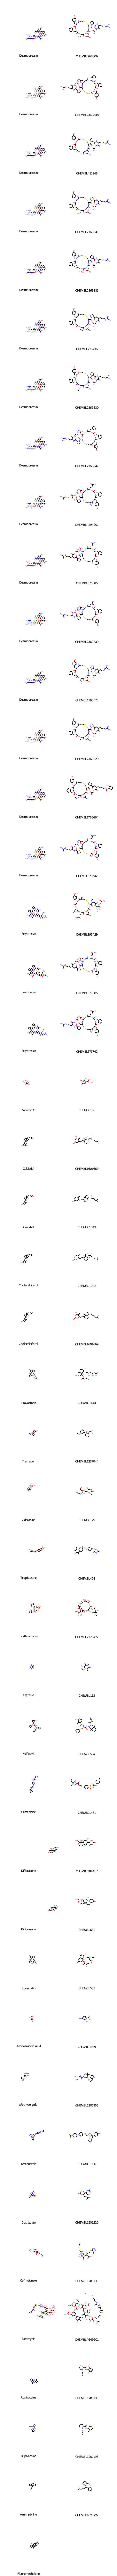

In [187]:
Draw.MolsToGridImage(similar_molecules_to_draw, molsPerRow = 2, maxMols = int(len(similar_molecules_to_draw)/2), subImgSize = (300, 300), legends = names)

## Create a scatter plot of logP and TPSA descriptors for the ligand set and the DrugBank dataset

In [59]:
# calculate the descriptors for the ligand set
data["logP"] = data["molecule"].apply(Descriptors.MolLogP)
data["TPSA"] = data["molecule"].apply(Descriptors.TPSA)

# calculate the descriptors for the drugbank dataset
drugbank_df["logP"] = drugbank_df["molecule"].apply(Descriptors.MolLogP)
drugbank_df["TPSA"] = drugbank_df["molecule"].apply(Descriptors.TPSA)

In [60]:
# combine the dataframes
data["source"] = "vasopressin"
drugbank_df["source"] = "drugbank"

combined_df = data.append(drugbank_df, ignore_index = True)

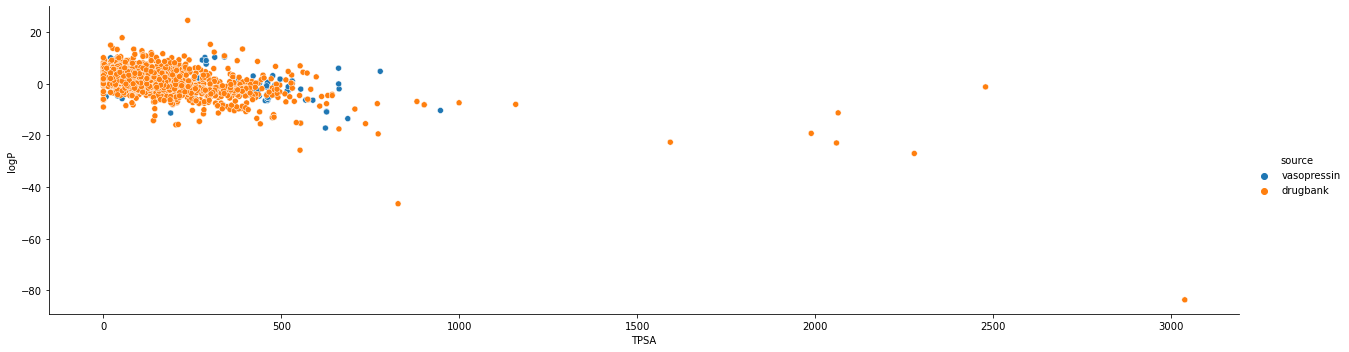

In [65]:
seaborn.relplot(data = combined_df, x = "TPSA", y = "logP", hue = "source", aspect = 3.5)
plt.show()